In [2]:
import pandas as pd
import op
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime

In [30]:
#get SMU and DMM files
smu_data=list(op.getting_files())
l1=len(smu_data)
dmm_data=list(op.getting_files())
l2=len(dmm_data)

In [31]:
dates=pd.to_datetime(['2020-12-11 19:45:07',
                      '2020-12-15 12:46:07',
                      '2020-12-15 20:35:07',
                      '2020-12-17 12:26:35',
                      '2020-12-17 20:54:31'])

In [76]:
for i in tqdm(range(l1)):
    #smu data processing
    if i==0:
        df1=pd.read_csv(smu_data[i],header=0,names=['num','Time','Id','Vd','Power','Resistance'])
    else:
        df1=pd.read_csv(smu_data[i],skiprows=35,header=0,names=['num','Time','Id','Vd','Power','Resistance'])
    
    df1.drop(['num','Power','Resistance'],axis=1,inplace=True)
    df1['Datetime']=dates[i]+pd.to_timedelta(df1['Time'],unit='S')
    df1.index=df1['Datetime']
    df1.drop(['Time','Datetime'],axis=1,inplace=True)
    df1=df1.resample('1S').mean()
    df1.fillna(value=None,method='backfill',limit=2,inplace=True)
    df1=df1.resample('5S').mean()
    
    #dmm data processing
    if i==0:
        df2=pd.read_csv(dmm_data[i],header=0,names=['num','Time','Temp'])
    
    else:
        df2=pd.read_csv(dmm_data[i],skiprows=26,header=0,names=['num','Time','Temp'])
    
    df2['Datetime']=dates[i]+pd.to_timedelta(df2['Time'],unit='S')
    df2.index=df2['Datetime']
    df2.drop(['num','Time','Datetime'],axis=1,inplace=True)
    df2=df2.resample('1S').mean()
    df2.fillna(value=None,method='backfill',limit=2,inplace=True)
    df2=df2.resample('5S').mean()
    
    #merging smu and dmm data
    df = pd.merge(df1,df2,left_index=True,right_index=True,how='inner')
    df.dropna(inplace=True)
#     print(df.info())
    op.append_df_to_excel('smu-dmm data merged.xlsx',df)
    

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:00<00:00, 12.07s/it]


In [64]:
# # dff=pd.read_csv(smu_data[0],header=0,names=['num','Time','Id','Vd','Power','Resistance'])

# dff=pd.read_csv(smu_data[4],skiprows=35,header=0,names=['num','Time','Id','Vd','Power','Resistance'])

# dff.drop(['num','Power','Resistance'],axis=1,inplace=True)
# dff['Datetime']=dates[4]+pd.to_timedelta(dff['Time'],unit='S')
# dff.index=dff['Datetime']
# dff.drop(['Time','Datetime'],axis=1,inplace=True)
# dff=dff.resample('1S').mean()
# # r = pd.date_range(start=dff.index.min(),end=dff.index.max(),freq='1s')
# # dff = dff.reindex(r)
# dff.fillna(value=None,method='backfill',limit=2,inplace=True)
# dff=dff.resample('5S').mean()

In [75]:
# dff.info()

In [70]:
# # dff2=pd.read_csv(dmm_data[0],header=0,names=['num','Time','Temp'])

# dff2=pd.read_csv(dmm_data[4],skiprows=26,header=0,names=['num','Time','Temp'])

# dff2['Datetime']=dates[4]+pd.to_timedelta(dff2['Time'],unit='S')
# dff2.index=dff2['Datetime']
# dff2.drop(['num','Time','Datetime'],axis=1,inplace=True)
# dff2=dff2.resample('1S').mean()
# dff2.fillna(value=None,method='backfill',limit=2,inplace=True)
# dff2=dff2.resample('5S').mean()

In [74]:
# dff2.info()

In [77]:
data = list(op.getting_files())

In [78]:
df = pd.read_excel(data[0],index_col='Datetime')

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137136 entries, 2020-12-11 19:45:05 to 2020-12-21 09:29:40
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      137136 non-null  float64
 1   Vd      137136 non-null  float64
 2   Temp    137136 non-null  float64
dtypes: float64(3)
memory usage: 4.2+ MB


In [80]:
#current filter parameters
Uel=0.024
set_curr=0.67
variation=0.67*Uel

#voltage correction parameters
B=-0.27

In [81]:
'''filtering the data'''
df1=df[(df['Temp']<78) & (df['Temp']>72)]                                   # temperature filter
df1=df1[(df1['Id']<(set_curr+variation)) & (df1['Id']>(set_curr-variation))]     # current filter

In [82]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99552 entries, 2020-12-11 20:02:05 to 2020-12-21 09:29:40
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      99552 non-null  float64
 1   Vd      99552 non-null  float64
 2   Temp    99552 non-null  float64
dtypes: float64(3)
memory usage: 3.0+ MB


In [83]:
'''Adding Temperature corrected voltage(Vd_corr)'''
df1['Vd_corr']=B*(75-df1['Temp'])+df1['Vd']

In [84]:
'''Adding %change in Vd_corr''' 
df1['Vd_corr_%change']=0
for i in tqdm(range(len(df1))):
    if i==0:
        df1.iloc[i,4]=0
    else:
        df1.iloc[i,4]=100*(df1['Vd_corr'][i]-df1['Vd_corr'][i-1])/(df1['Vd_corr'][i-1])

100%|███████████████████████████████████████████████████████████████████████████| 99552/99552 [14:58<00:00, 110.77it/s]


In [85]:
df4 = df1.copy()

In [86]:
# df4=df4.resample('5S').mean()
df4.dropna(inplace=True)
df4.reset_index(inplace=True)
df4.rename(columns={'index':'date'},inplace=True)

In [87]:
df4.head()

,Datetime,Id,Vd,Temp,Vd_corr,Vd_corr_%change
0,2020-12-11 20:02:05,0.669987,36.106913,72.009622,35.299511,0.000000
1,2020-12-11 20:02:10,0.669987,36.100464,72.046185,35.302934,0.009696
2,2020-12-11 20:02:15,0.669987,36.096130,72.069633,35.304931,0.005658
3,2020-12-11 20:02:20,0.669987,36.089508,72.106030,35.308136,0.009078
4,2020-12-11 20:02:25,0.669988,36.083206,72.132623,35.309014,0.002487


In [88]:
df4['avg_Vd_corr%change']=df4.iloc[:,5].rolling(window=720).mean()

In [91]:
df4=df4[(df4['Vd_corr_%change']>-0.15) & (df4['Vd_corr_%change']<0.25)]

In [94]:
df4.to_excel('letid_data_SMU-DMM_filtered.xlsx')

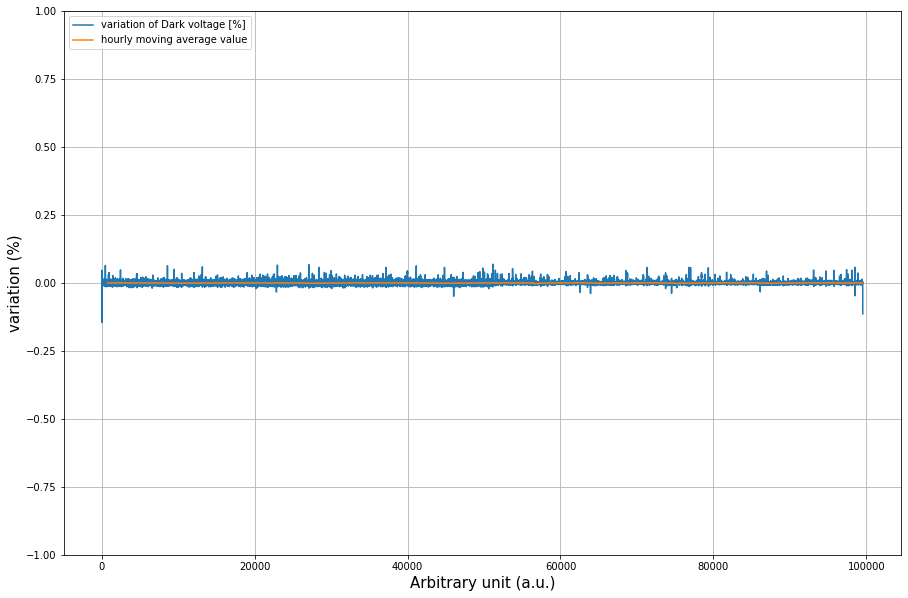

In [93]:
plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(df4['Vd_corr_%change'],label='variation of Dark voltage [%]')
plt.plot(df4['avg_Vd_corr%change'],label='hourly moving average value')
plt.legend(loc=2)
plt.xlabel('Arbitrary unit (a.u.)',fontsize=15)
plt.ylabel('variation (%)',fontsize=15)
plt.ylim(-1,1)
plt.savefig('letid_data_SMU-DMM_filtered_plot.jpeg')
plt.show()